In [1]:
import argparse
import logging
import math
import os
import random
from pathlib import Path
from typing import Iterable, Optional

import numpy as np
import torch
import torch.nn.functional as F
import torch.utils.checkpoint
import torch.nn as nn
from accelerate import Accelerator
from accelerate.logging import get_logger
from accelerate.utils import set_seed
from datasets import load_dataset
from diffusers import AutoencoderKL, DDPMScheduler, StableDiffusionPipeline, UNet2DConditionModel, DDIMScheduler, PNDMScheduler, ControlNetModel
from diffusers.optimization import get_scheduler
from huggingface_hub import HfFolder, Repository, whoami
from torchvision import transforms
from tqdm.auto import tqdm
from transformers import CLIPTextModel, CLIPTokenizer, CLIPVisionModel
from diffusers import StableDiffusionInpaintPipeline, StableDiffusionControlNetInpaintPipeline

In [2]:
accelerator = Accelerator(
        gradient_accumulation_steps=1,
        mixed_precision='fp16',
        log_with='tensorboard',
        # logging_dir='logs',
    )

/DATA/ocr_team_2/miniconda3/envs/diffusion/lib/python3.10/site-packages/accelerate/accelerator.py:371: UserWarning: `log_with=tensorboard` was passed but no supported trackers are currently installed.
  warnings.warn(f"`log_with={log_with}` was passed but no supported trackers are currently installed.")


In [3]:
pretrained_model_name_or_path = 'stabilityai/stable-diffusion-2'
text_encoder = CLIPTextModel.from_pretrained(
    pretrained_model_name_or_path,
    subfolder="text_encoder",
    revision='fp16',
)

tokenizer = CLIPTokenizer.from_pretrained(
    pretrained_model_name_or_path,
    subfolder='tokenizer'
)
vae = AutoencoderKL.from_pretrained(
    pretrained_model_name_or_path,
    subfolder="vae",
    revision="fp16",
)

vae_scale_factor = 2 ** (len(vae.config.block_out_channels) - 1)
unet = UNet2DConditionModel.from_pretrained(
    pretrained_model_name_or_path,
    subfolder="unet",
    revision='fp16',
)

in_channels = 8
out_channels = unet.conv_in.out_channels
unet.register_to_config(in_channels=in_channels)

with torch.no_grad():
    new_conv_in = nn.Conv2d(
        in_channels, out_channels, unet.conv_in.kernel_size, unet.conv_in.stride, unet.conv_in.padding
    )
    new_conv_in.weight.zero_()
    new_conv_in.weight[:, :4, :, :].copy_(unet.conv_in.weight)
    unet.conv_in = new_conv_in

controlnet = ControlNetModel.from_unet(unet)

In [4]:
vae.requires_grad_(False)
text_encoder.requires_grad_(False)
unet.requires_grad_(False)

UNet2DConditionModel(
  (conv_in): Conv2d(8, 320, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): Linear(in_features=320, out_features=1280, bias=True)
    (act): SiLU()
    (linear_2): Linear(in_features=1280, out_features=1280, bias=True)
  )
  (down_blocks): ModuleList(
    (0): CrossAttnDownBlock2D(
      (attentions): ModuleList(
        (0-1): 2 x Transformer2DModel(
          (norm): GroupNorm(32, 320, eps=1e-06, affine=True)
          (proj_in): LoRACompatibleLinear(in_features=320, out_features=320, bias=True)
          (transformer_blocks): ModuleList(
            (0): BasicTransformerBlock(
              (norm1): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
              (attn1): Attention(
                (to_q): Linear(in_features=320, out_features=320, bias=False)
                (to_k): Linear(in_features=320, out_features=320, bias=False)
                (to_v): Linear(in_featu

In [5]:
ci = torch.randn((1, 8, 64, 64))
prompt_emb = torch.randn((1, 4, 1024))
t = torch.tensor([3]).to(torch.int64)
control_image = torch.randn((1, 3, 512, 512))


In [6]:
out = controlnet(
                    ci,
                    t,
                    encoder_hidden_states=prompt_emb,
                    controlnet_cond=control_image,
                    conditioning_scale=0.3,
                    guess_mode=False,
                    return_dict=False,
                )

In [7]:
noise_pred = unet(
                    ci,
                    t,
                    encoder_hidden_states=prompt_emb,
                    cross_attention_kwargs=None,
                    down_block_additional_residuals=out[0],
                    mid_block_additional_residual=out[1],
                    return_dict=False,
                )[0]

In [8]:
noise_pred.shape

torch.Size([1, 4, 64, 64])

In [9]:
optimizer = torch.optim.AdamW(
        unet.parameters(),
        lr=0.0001,
)

In [10]:
noise_scheduler = PNDMScheduler.from_config(pretrained_model_name_or_path, subfolder="scheduler")

/DATA/ocr_team_2/miniconda3/envs/diffusion/lib/python3.10/site-packages/diffusers/configuration_utils.py:217: FutureWarning: It is deprecated to pass a pretrained model name or path to `from_config`.If you were trying to load a scheduler, please use <class 'diffusers.schedulers.scheduling_pndm.PNDMScheduler'>.from_pretrained(...) instead. Otherwise, please make sure to pass a configuration dictionary instead. This functionality will be removed in v1.0.0.
  deprecate("config-passed-as-path", "1.0.0", deprecation_message, standard_warn=False)


In [11]:
epochs=100
num_step_loader = 800
lr_scheduler = get_scheduler(
        'cosine',
        optimizer=optimizer,
        num_warmup_steps=300,
        num_training_steps = epochs*num_step_loader
    )

In [12]:
# p = StableDiffusionInpaintPipeline(
#         vae= vae,
#         text_encoder= text_encoder,
#         tokenizer= tokenizer,
#         unet= unet,
#         scheduler=noise_scheduler,
#         safety_checker=None,
#         feature_extractor=None
# )

In [13]:
p = StableDiffusionControlNetInpaintPipeline(
        vae= vae,
        text_encoder= text_encoder,
        tokenizer= tokenizer,
        unet= unet,
        scheduler=noise_scheduler,
        controlnet = controlnet,
        safety_checker=None,
        feature_extractor=None
)

You have disabled the safety checker for <class 'diffusers.pipelines.controlnet.pipeline_controlnet_inpaint.StableDiffusionControlNetInpaintPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


In [ ]:
p.save_pretrained('logs/')

In [10]:
from torch.utils.data import Dataset, DataLoader
class sd2se(Dataset):
    def __init__(self):
        pass

    def __len__(self):
        pass

    def __getitem__(self, idx):
        pass

In [11]:
weight_dtype = torch.float32

print(accelerator.mixed_precision)
if accelerator.mixed_precision == "fp16":
    weight_dtype = torch.float16
elif accelerator.mixed_precision == "bf16":
    weight_dtype = torch.bfloat16

# Move text_encode and vae to gpu.
# For mixed precision training we cast the text_encoder and vae weights to half-precision
# as these models are only used for inference, keeping weights in full precision is not required.
text_encoder.to(accelerator.device, dtype=weight_dtype)
vae.to(accelerator.device, dtype=weight_dtype)

fp16


AutoencoderKL(
  (encoder): Encoder(
    (conv_in): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (down_blocks): ModuleList(
      (0): DownEncoderBlock2D(
        (resnets): ModuleList(
          (0-1): 2 x ResnetBlock2D(
            (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
            (conv1): LoRACompatibleConv(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (norm2): GroupNorm(32, 128, eps=1e-06, affine=True)
            (dropout): Dropout(p=0.0, inplace=False)
            (conv2): LoRACompatibleConv(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (nonlinearity): SiLU()
          )
        )
        (downsamplers): ModuleList(
          (0): Downsample2D(
            (conv): LoRACompatibleConv(128, 128, kernel_size=(3, 3), stride=(2, 2))
          )
        )
      )
      (1): DownEncoderBlock2D(
        (resnets): ModuleList(
          (0): ResnetBlock2D(
            (norm1): GroupNorm(32, 128, ep

In [12]:
max_train_step = 10000
epochs = 50


for epoch in range(epochs):
    unet.train()
    train_loss = 0.0
    for step, batch in enumerate(train_dataloader):
        with accelerator.accumulate(unet):
            # Convert images to latent space
            _,_,h,w = batch["pixel_values"].shape()
            latents = vae.encode(batch["pixel_values"].to(weight_dtype)).latent_dist.sample()
            mask_latent = vae.encode(batch['image_mask'].to(weight_dtype)).latent_dist.sample()
            latents = latents * 0.18215
            mask_latent = latent * 0.18215

            mask = batch['mask']
            mask = torch.nn.functional.interpolate(
                mask, size=(h // vae_scale_factor, w // vae_scale_factor)
            )


            # Sample noise that we'll add to the latents
            noise = torch.randn_like(latents)
            bsz = latents.shape[0]
            # Sample a random timestep for each image
            timesteps = torch.randint(0, noise_scheduler.num_train_timesteps, (bsz,), device=latents.device)
            timesteps = timesteps.long()

            # Add noise to the latents according to the noise magnitude at each timestep
            # (this is the forward diffusion process)
            noisy_latents = noise_scheduler.add_noise(latents, noise, timesteps)

            noisy_latents = torch.cat([noisy_latents, mask, mask_latent], axis=1)
            

            # Get the text embedding for conditioning
            encoder_hidden_states = text_encoder(batch["input_ids"])[0]

            # Get the target for loss depending on the prediction type
            if noise_scheduler.config.prediction_type == "epsilon":
                target = noise
            elif noise_scheduler.config.prediction_type == "v_prediction":
                target = noise_scheduler.get_velocity(latents, noise, timesteps)
            else:
                raise ValueError(f"Unknown prediction type {noise_scheduler.config.prediction_type}")

            # Predict the noise residual and compute loss
            model_pred = unet(noisy_latents, timesteps, encoder_hidden_states).sample
            loss = F.mse_loss(model_pred.float(), target.float(), reduction="mean")

            # Gather the losses across all processes for logging (if we use distributed training).
            avg_loss = accelerator.gather(loss.repeat(train_batch_size)).mean()
            train_loss += avg_loss.item() / args.gradient_accumulation_steps

            # Backpropagate
            accelerator.backward(loss)
            if accelerator.sync_gradients:
                accelerator.clip_grad_norm_(unet.parameters(), args.max_grad_norm)
            optimizer.step()
            lr_scheduler.step()
            optimizer.zero_grad()

        # Checks if the accelerator has performed an optimization step behind the scenes
        if accelerator.sync_gradients:
            progress_bar.update(1)
            global_step += 1
            accelerator.log({"train_loss": train_loss}, step=global_step)
            train_loss = 0.0

        logs = {"step_loss": loss.detach().item(), "lr": lr_scheduler.get_last_lr()[0]}

        print(logs)

        if global_step >= args.max_train_steps:
            break

# Create the pipeline using the trained modules and save it.
accelerator.wait_for_everyone()
if accelerator.is_main_process:
    unet = accelerator.unwrap_model(unet)

    pipeline = StableDiffusionInpaintPipeline(
        vae= vae,
        text_encoder= text_encoder,
        tokenizer= tokenizer,
        unet= unet,
        scheduler=noise_scheduler,
        safety_checker=None,
        feature_extractor=None
    )
    pipeline.save_pretrained(args.output_dir)

accelerator.end_training()

In [50]:
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel, UniPCMultistepScheduler
import torch
from PIL import Image

controlnet = [
    ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-openpose", torch_dtype=torch.float16),
    # ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-canny", torch_dtype=torch.float16),
]

pipe = StableDiffusionControlNetPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5", controlnet=controlnet, torch_dtype=torch.float16
)
pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)

# pipe.enable_xformers_memory_efficient_attention()
pipe.enable_model_cpu_offload()

prompt = "indian girl in punjabi kurta, ulra quality"
# negative_prompt = "monochrome, lowres, bad anatomy, worst quality, low quality"

generator = torch.Generator(device="cpu").manual_seed(1)

images = Image.open("download-pose-3.png")

image = pipe(
    prompt,
    [images],
    num_inference_steps=30,
    generator=generator,
    # negative_prompt=negative_prompt,
    controlnet_conditioning_scale=[1.0],
).images[0]

image.save('test.png')




Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


  0%|          | 0/30 [00:00<?, ?it/s]

In [25]:
# prompt = "lion roaring on the park bench"
# image = p(prompt=prompt, image=init_image, mask_image=mask_image,  control_image=init_image,guidance_scale = 8.0, num_inference_steps = 60).images[0]

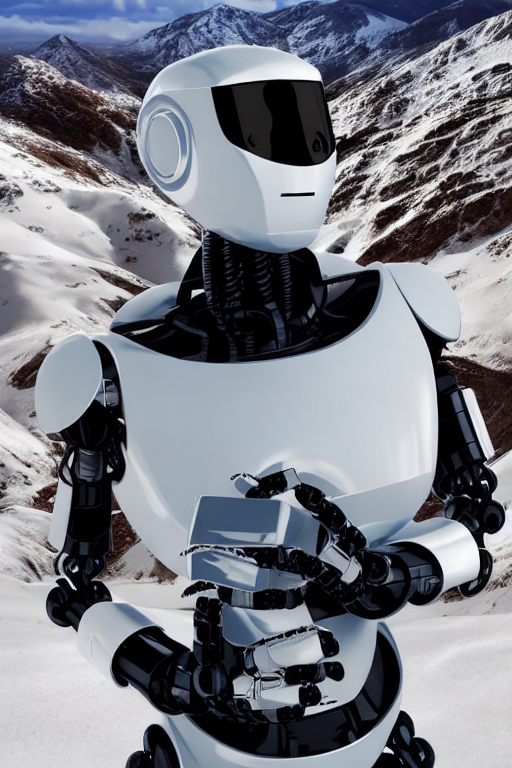

In [26]:
image